Projeto: CharityAI - Facilitar a conexão de doadores e instituições
=============================================================================

* Objetivo:
O CharityAI é um sistema de Question Answering sobre Grafos RDF,
desenvolvido para conectar doadores a instituições de caridade, localizando instuicoes que precisam de determinado item por bairro.

* Metodologia:
O sistema utiliza LLM, para traduzir a pergunta do usuario em query SPARQL.

* Testes automaticos e Metricas:
Para validar a solução foi definido um conjunto de testes automaticos e metricas como F1.




In [2]:
!pip install langchain langchain-openai langchain-community gradio rdflib

In [3]:
import os
import logging
import re
from typing import Any
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, AIMessage
from openai import OpenAI
from rdflib import Graph

# RDF

In [4]:
RDF_DATA = """
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ex: <http://www.example.org/ontologia-suportesocial#> .

# ===========================
# Classes
# ===========================
ex:Pessoa a rdfs:Class .
ex:Instituicao a rdfs:Class .
ex:ItemDoacao a rdfs:Class .
ex:CategoriaVestuario a rdfs:Class .
ex:Bairro a rdfs:Class .

# ===========================
# Categorias de itens
# ===========================
ex:Roupas a ex:CategoriaVestuario ; rdfs:label "Roupas" .
ex:Calcados a ex:CategoriaVestuario ; rdfs:label "Calçados" .
ex:Sapatos a ex:CategoriaVestuario ; rdfs:label "Sapatos" .
ex:Acessorios a ex:CategoriaVestuario ; rdfs:label "Acessórios" .
ex:RoupasInfantis a ex:CategoriaVestuario ; rdfs:subClassOf ex:Roupas ; rdfs:label "Roupas Infantis" .
ex:RoupasAdultas a ex:CategoriaVestuario ; rdfs:subClassOf ex:Roupas ; rdfs:label "Roupas Adultas" .
ex:SapatosInfantis a ex:CategoriaVestuario ; rdfs:subClassOf ex:Sapatos, ex:RoupasInfantis ; rdfs:label "Sapatos Infantis" .
ex:Meias a ex:CategoriaVestuario ; rdfs:subClassOf ex:Calcados ; rdfs:label "Meias" .

# ===========================
# Itens de doação
# ===========================
ex:casacos a ex:ItemDoacao ; ex:categoria ex:RoupasAdultas ; rdfs:label "Casacos" .
ex:vestidos_infantis a ex:ItemDoacao ; ex:categoria ex:RoupasInfantis ; rdfs:label "Vestidos Infantis" .
ex:calca_jeans a ex:ItemDoacao ; ex:categoria ex:RoupasAdultas ; rdfs:label "Calça Jeans" .
ex:sapatos a ex:ItemDoacao ; ex:categoria ex:Sapatos ; rdfs:label "Sapatos" .
ex:tenis_infantil a ex:ItemDoacao ; ex:categoria ex:SapatosInfantis ; rdfs:label "Tênis Infantil" .
ex:cintos a ex:ItemDoacao ; ex:categoria ex:Acessorios ; rdfs:label "Cintos" .
ex:meias_infantis a ex:ItemDoacao ; ex:categoria ex:Meias ; rdfs:label "Meias Infantis" .
ex:jaquetas a ex:ItemDoacao ; ex:categoria ex:RoupasAdultas ; rdfs:label "Jaquetas" .
ex:blusas_infantis a ex:ItemDoacao ; ex:categoria ex:RoupasInfantis ; rdfs:label "Blusas Infantis" .

# ===========================
# Bairros
# ===========================
ex:VilaMariana a ex:Bairro ; rdfs:label "Vila Mariana" .
ex:Centro a ex:Bairro ; rdfs:label "Centro" .
ex:Pinheiros a ex:Bairro ; rdfs:label "Pinheiros" .
ex:Liberdade a ex:Bairro ; rdfs:label "Liberdade" .
ex:Santana a ex:Bairro ; rdfs:label "Santana" .
ex:Tucuruvi a ex:Bairro ; rdfs:label "Tucuruvi" .
ex:JardimPaulista a ex:Bairro ; rdfs:label "Jardim Paulista" .

# ===========================
# Pessoas
# ===========================
ex:joao a ex:Pessoa ; ex:localizadoEm ex:VilaMariana ; rdfs:label "João Silva" .
ex:maria a ex:Pessoa ; ex:localizadoEm ex:Pinheiros ; rdfs:label "Maria Oliveira" .
ex:pedro a ex:Pessoa ; ex:localizadoEm ex:Centro ; rdfs:label "Pedro Costa" .
ex:ana a ex:Pessoa ; ex:localizadoEm ex:VilaMariana ; rdfs:label "Ana Souza" .
ex:carlos a ex:Pessoa ; ex:localizadoEm ex:Liberdade ; rdfs:label "Carlos Santos" .
ex:lucas a ex:Pessoa ; ex:localizadoEm ex:JardimPaulista ; rdfs:label "Lucas Pereira" .

# ===========================
# Instituições
# ===========================
# Vila Mariana - 2 instituições
ex:instituicao1 a ex:Instituicao ; ex:localizadoEm ex:VilaMariana ; ex:precisaDe ex:RoupasInfantis, ex:Sapatos ; rdfs:label "Abrigo Esperança" .
ex:instituicao2 a ex:Instituicao ; ex:localizadoEm ex:VilaMariana ; ex:precisaDe ex:RoupasAdultas, ex:Acessorios ; rdfs:label "Lar do Idoso" .

# Centro - 1 instituição (nenhum caso para acessórios)
ex:instituicao3 a ex:Instituicao ; ex:localizadoEm ex:Centro ; ex:precisaDe ex:Roupas, ex:Sapatos ; rdfs:label "Casa da Acolhida" .

# Pinheiros - 3 instituições
ex:instituicao4 a ex:Instituicao ; ex:localizadoEm ex:Pinheiros ; ex:precisaDe ex:RoupasInfantis, ex:SapatosInfantis ; rdfs:label "Projeto Cidadania" .
ex:instituicao5 a ex:Instituicao ; ex:localizadoEm ex:Pinheiros ; ex:precisaDe ex:RoupasAdultas, ex:Acessorios ; rdfs:label "Centro Comunitário" .
ex:instituicao6 a ex:Instituicao ; ex:localizadoEm ex:Pinheiros ; ex:precisaDe ex:RoupasAdultas, ex:Sapatos ; rdfs:label "ONG Crescer" .

# Liberdade - 2 instituições
ex:instituicao7 a ex:Instituicao ; ex:localizadoEm ex:Liberdade ; ex:precisaDe ex:Roupas ; rdfs:label "Fundação Solidária" .
ex:instituicao8 a ex:Instituicao ; ex:localizadoEm ex:Liberdade ; ex:precisaDe ex:RoupasAdultas, ex:SapatosInfantis ; rdfs:label "Associação Amiga" .

# Santana - 1 instituição
ex:instituicao9 a ex:Instituicao ; ex:localizadoEm ex:Santana ; ex:precisaDe ex:Meias ; rdfs:label "Fundo Comunitário" .

# Tucuruvi - 1 instituição
ex:instituicao10 a ex:Instituicao ; ex:localizadoEm ex:Tucuruvi ; ex:precisaDe ex:RoupasAdultas, ex:Sapatos ; rdfs:label "Associação Crescer" .

# Jardim Paulista - 0 instituições
"""

In [5]:
# Cria um grafo RDF em memória e carrega os dados fornecidos.
# O objeto Graph() é a estrutura principal da biblioteca rdflib que armazena
# triplas RDF (sujeito, predicado, objeto).
# Em seguida, o método parse() lê o conteúdo definido em RDF_DATA,
# interpretando-o no formato Turtle (.ttl) e adicionando as triplas ao grafo.
g = Graph()
g.parse(data=RDF_DATA, format="turtle")

<Graph identifier=N971c959c386f41d7bdf1396fbd1761d4 (<class 'rdflib.graph.Graph'>)>

# LLM Config

In [6]:
# Importa utilitários para acessar variáveis seguras no Google Colab.
# A chave da API Groq deve ser salva no "secret" do Colab (menu: Tools > Secrets)
# com o nome "GROQ_API_KEY", garantindo que não seja exposta diretamente no código.
#
# Em seguida, a chave é recuperada via userdata.get() e configurada como
# variáveis de ambiente, simulando o padrão da API da OpenAI, mas apontando
# para a URL do endpoint da Groq.
from google.colab import userdata
import os

GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ["OPENAI_API_KEY"] = GROQ_API_KEY
os.environ["OPENAI_API_BASE"] = "https://api.groq.com/openai/v1"

In [7]:
def list_groq_models():
    """
    Lista os modelos disponíveis na API da Groq.

    A função cria um cliente OpenAI apontando para o endpoint da Groq
    (https://api.groq.com/openai/v1) utilizando a chave de API salva
    em GROQ_API_KEY. Em seguida, faz uma chamada para obter todos os
    modelos disponíveis e retorna apenas os IDs em forma de lista.

    Returns
    -------
    list[str] | str
        - Lista de IDs dos modelos disponíveis, se a chamada for bem-sucedida.
        - Mensagem de erro em formato string caso a requisição falhe.
    """
    client = OpenAI(
        api_key=GROQ_API_KEY,
        base_url="https://api.groq.com/openai/v1"
    )
    try:
        models = client.models.list()
        return [m.id for m in models.data]
    except Exception as e:
        return f"Erro ao listar modelos: {e}"

# Teste rápido
print(list_groq_models())

['qwen/qwen3-32b', 'openai/gpt-oss-20b', 'groq/compound-mini', 'moonshotai/kimi-k2-instruct', 'llama-3.1-8b-instant', 'whisper-large-v3', 'llama-3.3-70b-versatile', 'playai-tts', 'whisper-large-v3-turbo', 'moonshotai/kimi-k2-instruct-0905', 'deepseek-r1-distill-llama-70b', 'openai/gpt-oss-120b', 'meta-llama/llama-prompt-guard-2-22m', 'meta-llama/llama-4-maverick-17b-128e-instruct', 'playai-tts-arabic', 'meta-llama/llama-prompt-guard-2-86m', 'gemma2-9b-it', 'allam-2-7b', 'meta-llama/llama-4-scout-17b-16e-instruct', 'groq/compound', 'meta-llama/llama-guard-4-12b']


In [8]:
def init_llm(model_name="llama-3.1-8b-instant"):
    """
    Inicializa um modelo de linguagem hospedado na Groq.

    Esta função cria uma instância do `ChatOpenAI` configurada para usar
    um modelo específico disponível na API da Groq. O nome do modelo pode
    ser informado como parâmetro, sendo "llama-3.1-8b-instant" o padrão.

    Parameters
    ----------
    model_name : str, optional
        Nome do modelo Groq a ser utilizado.
        Exemplos comuns: "llama-3.1-8b-instant", "llama-3.1-70b-versatile".

    Returns
    -------
    ChatOpenAI
        Objeto de modelo de linguagem configurado para chamadas de geração
        de texto e chat via API da Groq.
    """
    return ChatOpenAI(model=model_name, temperature=0.0)


In [9]:
# Funcao para testar a LLM
def test_llm(llm, prompt="Explique a diferença entre LLM e RAG em linguagem simples."):
    """
    Testa se o modelo LLM (Large Language Model) está funcionando corretamente.

    A função envia um prompt simples ao modelo fornecido e retorna a resposta.
    Caso a chamada ao LLM falhe, a função captura a exceção e retorna uma
    mensagem de erro.

    Parameters
    ----------
    llm : ChatOpenAI
        Instância do modelo de linguagem inicializada previamente (ex: via init_llm).
    prompt : str, optional
        Texto da pergunta usada para o teste. Por padrão, pede uma explicação
        da diferença entre LLM e RAG.

    Returns
    -------
    str
        - Conteúdo da resposta gerada pelo modelo, se bem-sucedido.
        - Mensagem de erro em caso de falha na chamada.
    """
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        if hasattr(response, "content"):
            return response.content
        return str(response)
    except Exception as e:
        return f"Erro ao chamar LLM: {e}"

# Testando
llm = init_llm()
print(test_llm(llm))

Vou explicar de forma simples.

**LLM (Large Language Model)**: 
Um LLM é um modelo de linguagem grande que aprende a entender e gerar texto de forma automática. É como um grande livro de referência que contém toda a sabedoria e conhecimento do mundo. Quando você pergunta algo ao LLM, ele usa essa sabedória para criar uma resposta baseada no que já aprendeu.

**RAG (Retrieval-Augmented Generation)**:
Um RAG é um modelo que combina as habilidades dos LLM com a capacidade de procurar informações em uma grande base de dados. É como um supercomputador que não apenas entende o que você está perguntando, mas também é capaz de procurar o que você procura em uma biblioteca muito grande.

A diferença entre os dois é que:

* O LLM é mais focado em criar textos novos e genéricos;
* O RAG é mais focado em buscar e gerar textos específicos e precisos.

Em outras palavras, o LLM é como um artista que cria algo novo e original, enquanto o RAG é como um pesquisador que busca informações específicas e 

# Prompt SPARQL Few-shots e Zero Shot

In [10]:
# Prompt Few-shot

prompt_template = PromptTemplate(
    input_variables=["question"],
    template="""
Você é um assistente especializado em gerar queries SPARQL a partir de perguntas em linguagem natural.
Use o seguinte RDF como referência:

RDF:
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ex: <http://www.example.org/ontologia-suportesocial#> .

Sua base de conhecimento usa os seguintes termos:
- Classes: ex:Pessoa, ex:Instituicao, ex:ItemDoacao, ex:CategoriaVestuario, ex:Bairro
- Categorias de Itens (URI): ex:Roupas, ex:Sapatos, ex:Acessorios, ex:RoupasInfantis, ex:RoupasAdultas, ex:SapatosInfantis, ex:Meias
- Relações principais: ex:localizadoEm, ex:precisaDe

Regras e instruções (importante):
1. **RETORNE APENAS** a query SPARQL (SELECT). **SEM** explicações, texto extra ou comentários.
2. Use **somente URIs** que existem no RDF acima. **Não** invente URIs nem nomes.
3. Sempre use as classes corretas quando necessário (por exemplo `a ex:Instituicao`).
4. Para filtros de bairro, use **somente** URIs de bairros (ex: `ex:Pinheiros`, `ex:Centro`, etc).
5. Para a versão simples/sólida do mapeamento, **conecte `ex:precisaDe` diretamente a uma categoria**. Exemplo:

?instituicao a ex:Instituicao ;
ex:localizadoEm ex:Pinheiros ;
ex:precisaDe ex:Sapatos ;
rdfs:label ?nome .

6. Se a pergunta mencionar itens específicos (ex.: "tênis infantil"), use a categoria apropriada do RDF.
7. Sempre retorne também o rótulo com `rdfs:label ?nome`.
9. Nomeie variáveis de forma descritiva: ?instituicao, ?nome, ?item, ?bairro.
10. Mapeie sinônimos para categorias RDF:
 - "roupas", "doar roupas" → ex:Roupas / ex:RoupasAdultas / ex:RoupasInfantis
 - "sapatos", "calçados" → ex:Sapatos / ex:SapatosInfantis
 - "acessórios" → ex:Acessorios
 - "meias" → ex:Meias

Exemplos genéricos (não casos literais):

- Pergunta sobre instituições em um bairro:
SELECT ?instituicao ?nome WHERE {{
?instituicao a ex:Instituicao ;
ex:localizadoEm ex:<BairroDesejado> ;
rdfs:label ?nome .
}}

- Pergunta sobre onde doar uma categoria:
SELECT ?instituicao ?nome WHERE {{
?instituicao a ex:Instituicao ;
ex:localizadoEm ex:<BairroDesejado> ;
ex:precisaDe ex:<CategoriaDesejada> ;
rdfs:label ?nome .
}}

Observação:
- Para filtros avançados não disponíveis no RDF, gere uma query simples.
- Mantenha a query **válida** e executável.

Agora, gere a query SPARQL para a pergunta do usuário:
Pergunta: {question}
"""
)

In [11]:
#Prompt Zero-shot

prompt_template_zeroshot = PromptTemplate(
    input_variables=["question"],
    template="""
Você é um assistente especializado em gerar queries SPARQL a partir de perguntas em linguagem natural.
Use o seguinte RDF como referência:

RDF:
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ex: <http://www.example.org/ontologia-suportesocial#> .

Sua base de conhecimento usa os seguintes termos:
- Classes: ex:Pessoa, ex:Instituicao, ex:ItemDoacao, ex:CategoriaVestuario, ex:Bairro
- Categorias de Itens (URI): ex:Roupas, ex:Sapatos, ex:Acessorios, ex:RoupasInfantis, ex:RoupasAdultas, ex:SapatosInfantis, ex:Meias
- Relações principais: ex:localizadoEm, ex:precisaDe

Regras e instruções (importante):
1. **RETORNE APENAS** a query SPARQL (SELECT). **SEM** explicações, texto extra ou comentários.
2. Use **somente URIs** que existem no RDF acima. **Não** invente URIs nem nomes.
3. Sempre use as classes corretas quando necessário (por exemplo `a ex:Instituicao`).
4. Para filtros de bairro, use **somente** URIs de bairros (ex: `ex:Pinheiros`, `ex:Centro`, etc).
5. Para a versão simples/sólida do mapeamento, **conecte `ex:precisaDe` diretamente a uma categoria**. Exemplo:

?instituicao a ex:Instituicao ;
ex:localizadoEm ex:Pinheiros ;
ex:precisaDe ex:Sapatos ;
rdfs:label ?nome .

6. Se a pergunta mencionar itens específicos (ex.: "tênis infantil"), use a categoria apropriada do RDF.
7. Sempre retorne também o rótulo com `rdfs:label ?nome`.
9. Nomeie variáveis de forma descritiva: ?instituicao, ?nome, ?item, ?bairro.
10. Mapeie sinônimos para categorias RDF:
 - "roupas", "doar roupas" → ex:Roupas / ex:RoupasAdultas / ex:RoupasInfantis
 - "sapatos", "calçados" → ex:Sapatos / ex:SapatosInfantis
 - "acessórios" → ex:Acessorios
 - "meias" → ex:Meias

 Agora, gere a query SPARQL para a pergunta do usuário:
Pergunta: {question}
"""
)

In [12]:
# Print template
print(prompt_template)
print(prompt_template.format(question="Teste rápido"))
print(prompt_template_zeroshot)
print(prompt_template_zeroshot.format(question="Teste rápido"))

input_variables=['question'] input_types={} partial_variables={} template='\nVocê é um assistente especializado em gerar queries SPARQL a partir de perguntas em linguagem natural.\nUse o seguinte RDF como referência:\n\nRDF:\n@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n@prefix ex: <http://www.example.org/ontologia-suportesocial#> .\n\nSua base de conhecimento usa os seguintes termos:\n- Classes: ex:Pessoa, ex:Instituicao, ex:ItemDoacao, ex:CategoriaVestuario, ex:Bairro\n- Categorias de Itens (URI): ex:Roupas, ex:Sapatos, ex:Acessorios, ex:RoupasInfantis, ex:RoupasAdultas, ex:SapatosInfantis, ex:Meias\n- Relações principais: ex:localizadoEm, ex:precisaDe\n\nRegras e instruções (importante):\n1. **RETORNE APENAS** a query SPARQL (SELECT). **SEM** explicações, texto extra ou comentários.\n2. Use **somente URIs** que existem no RDF acima. **Não** invente URIs nem nomes.\n3. Sempre use as classes corretas quando nece

# Processamento de SPARQL

In [13]:
# ======================================================
# Processamento de Perguntas em Linguagem Natural para SPARQL
# ======================================================
# Esta célula contém duas funções principais:
# 1. _extract_text_from_response: função utilitária que extrai o texto
#    retornado pelo LLM, tratando múltiplos formatos de resposta
#    (string simples, AIMessage, objetos com .content ou .generations).
# 2. generate_sparql: função que recebe uma pergunta em linguagem natural,
#    gera um prompt (zero-shot ou few-shot), envia ao LLM e retorna
#    a query SPARQL limpa e validada pronta para execução.
#
# Juntas, essas funções permitem transformar perguntas de usuários em
# queries SPARQL utilizáveis, tratando respostas complexas do modelo
# e garantindo consistência no resultado final.

def _extract_text_from_response(resp: Any) -> str:
    """
    Extrai o texto retornado pelo LLM em diferentes formatos possíveis.

    Essa função é necessária porque bibliotecas de LLM podem retornar
    respostas em múltiplas estruturas (string simples, AIMessage,
    objeto com .content ou .generations). A função detecta o tipo e
    extrai o conteúdo de texto de forma unificada.

    Parameters
    ----------
    resp : Any
        Objeto de resposta retornado pelo LLM (pode ser string, AIMessage,
        ou um objeto contendo `content` ou `generations`).

    Returns
    -------
    str
        Texto extraído da resposta, em formato unificado.
    """

    if isinstance(resp, str):
        return resp
    if isinstance(resp, AIMessage):
        return resp.content
    if hasattr(resp, "content"):
        return resp.content
    if hasattr(resp, "generations"):
        gens = resp.generations
        if gens and gens[0]:
            first = gens[0][0]
            if hasattr(first, "text"):
                return first.text
            if hasattr(first, "message") and hasattr(first.message, "content"):
                return first.message.content
    return str(resp)

def generate_sparql(llm, user_question: str,modo="few-shot") -> str:
    """
    Gera uma query SPARQL a partir de uma pergunta em linguagem natural.

    A função prepara o prompt de acordo com o modo escolhido
    (zero-shot ou few-shot), envia ao LLM e processa a resposta
    extraindo apenas a query SPARQL limpa.
    Também faz validações básicas para garantir que o resultado
    seja utilizável.

    Parameters
    ----------
    llm : ChatOpenAI
        Instância do modelo de linguagem já inicializada (ex: via init_llm).
    user_question : str
        Pergunta em linguagem natural feita pelo usuário.
    modo : str, optional
        Estratégia de prompting:
        - "zero-shot": gera query apenas com a instrução direta.
        - "few-shot": inclui exemplos no prompt (default).

    Returns
    -------
    str
        Query SPARQL limpa e validada.
        Caso ocorra algum erro, retorna uma string começando com
        "Erro ao gerar SPARQL: ...".
    """
    try:

        if modo == "zero-shot":
            prompt = prompt_template_zeroshot.format(question=user_question)

        else:
            prompt = prompt_template.format(question=user_question)

        # 🔹 Invocar LLM
        response = llm.invoke([HumanMessage(content=prompt)])
        print("🔹 Resposta LLM:", response)

        # 🔹 Extrair texto
        text = _extract_text_from_response(response)
        print("🔹 Texto extraído:", text)

        # 🔹 Limpeza de Markdown e palavras extras
        cleaned = text.strip()
        for marker in ["```sql", "```sparql", "```", "SPARQL", "sparql"]:
            cleaned = cleaned.replace(marker, "")

        # 🔹 Remover espaços em excesso e linhas vazias
        cleaned = "\n".join([line.strip() for line in cleaned.splitlines() if line.strip()])

        # 🔹 Garantir que tenha apenas uma query (pegando só o primeiro SELECT)
        match = re.search(r"(SELECT\s+.*?WHERE\s*{.*?})", cleaned, re.IGNORECASE | re.DOTALL)
        if match:
            cleaned = match.group(1)
        else:
            raise ValueError("Query não contém SELECT ou não é reconhecível.")

        # 🔹 Validação mínima: deve começar com SELECT e conter WHERE
        if not re.match(r"SELECT\s+\?.+\s+WHERE", cleaned, re.IGNORECASE):
            raise ValueError("Query não parece ser SPARQL válida")

        return cleaned

    except Exception as e:
        return f"Erro ao gerar SPARQL: {e}"

In [14]:
def run_query(sparql_query: str, graph):
    """
    Executa uma query SPARQL no grafo RDF fornecido.
    É tolerante a resultados incompletos (sem valor para alguma variável).

    Parâmetros:
    - sparql_query (str): query SPARQL (string).
    - graph (rdflib.Graph): grafo RDF carregado.

    Retorna:
    - list[dict]: lista de resultados, cada resultado como {variável: valor}.
    - str: mensagem de erro caso a query falhe.
    """
    try:
        qres = graph.query(sparql_query)
        vars_list = [str(v) for v in getattr(qres, "vars", [])]  # nomes das variáveis
        results = []

        for row in qres:
            row_dict = {}
            for i, var in enumerate(vars_list):
                try:
                    val = row[i]
                except Exception:
                    val = None
                row_dict[var] = str(val) if val is not None else ""
            results.append(row_dict)

        return results
    except Exception as e:
        return f"Erro ao executar query: {e}"

In [15]:
def clean_uri_results(results: str) -> str:
    """
    Pós-processa os resultados brutos para remover URIs entre parênteses
    ou isoladas em linhas.

    Regras aplicadas:
    - Remove qualquer URI entre parênteses, mantendo apenas o rótulo.
      Exemplo: "Casa da Acolhida (http://example.com/id/123)" → "Casa da Acolhida"
    - Se a linha for apenas uma URI, extrai apenas o último identificador.
      Exemplo: "http://example.com/id/123" → "123"
    - Remove linhas vazias ou apenas com espaços.

    Args:
        results (str): Texto bruto retornado pelo LLM ou consulta SPARQL.

    Returns:
        str: Texto limpo, uma linha por resultado.
    """
    if not results:
        return results

    cleaned = []
    for r in results.split("\n"):
        r = r.strip()
        if not r:
            continue

        # Caso 1: rótulo + URI no mesmo texto (Casa da Acolhida (http...))
        if "(" in r and "http" in r:
            r = r.split("(")[0].strip()

        # Caso 2: linha é só URI
        elif r.startswith("http://") or r.startswith("https://"):
            r = r.split("/")[-1].split("#")[-1]

        cleaned.append(r)

    return "\n".join(cleaned)

In [16]:
def process_llm_query_with_cleaning(user_question: str):
    """
    Processa a pergunta do usuário em linguagem natural e retorna os resultados limpos.

    Fluxo:
    1. Gera a query SPARQL a partir da pergunta, usando o LLM.
    2. Executa a query no grafo RDF carregado.
    3. Constrói uma string com os resultados (nome + URI).
    4. Limpa URIs redundantes ou poluídas usando `clean_uri_results`.

    Args:
        user_question (str): Pergunta em linguagem natural feita pelo usuário.

    Returns:
        Tuple[str, str]:
            - Primeira posição: resposta limpa (apenas rótulos, sem URIs poluídas).
            - Segunda posição: query SPARQL gerada.
    """
    # Gera a query SPARQL
    sparql_query = generate_sparql(llm, user_question)
    if sparql_query.startswith("Erro"):
        return sparql_query, ""

    # Executa a query no RDF
    try:
        results = run_query(sparql_query, graph=g)  # g é o grafo RDF carregado
        if results:
            # Converte cada dict em string: "Nome (URI)"
            results_str = "\n".join([f"{r['nome']} ({r['instituicao']})" for r in results])
        else:
            results_str = "⚠️ Nenhum resultado encontrado."
    except Exception as e:
        results_str = f"❌ Erro ao executar query: {e}"

    print("Resposta bruta:", results_str)

    # Limpa URIs
    resposta_limpa = clean_uri_results(results_str)
    print("Resposta limpa:", resposta_limpa)

    return resposta_limpa, sparql_query

# Testes automaticos com Few-shots e Zero-shot e metricas

In [17]:
# ======================================================
# Funções utilitárias para normalização de strings,
# comparação fuzzy e avaliação de resultados (TP, FP, FN).
# ======================================================
import unicodedata
from difflib import SequenceMatcher

def normalize_label(s):
    """
    Normaliza uma string para facilitar comparações.

    Passos:
      - Converte para string e remove espaços extras.
      - Remove acentos/diacríticos (NFKD).
      - Converte para minúsculas.
      - Substitui múltiplos espaços por um único.

    Args:
        s (str): Texto de entrada.

    Returns:
        str: String normalizada e limpa.
    """
    if s is None:
        return ""
    s = str(s)
    s = s.strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    return s

def fuzzy_equal(a, b, threshold=0.85):
    """
    Verifica se duas strings são semelhantes o suficiente.

    Critérios:
      - Normaliza ambas as strings (com `normalize_label`).
      - Retorna True se forem idênticas ou substring uma da outra.
      - Caso contrário, usa a similaridade do SequenceMatcher.

    Args:
        a (str): Primeira string.
        b (str): Segunda string.
        threshold (float): Limite mínimo de similaridade (0–1).

    Returns:
        bool: True se as strings forem consideradas equivalentes.
    """
    if a is None or b is None:
        return False
    a_n = normalize_label(a)
    b_n = normalize_label(b)
    if not a_n or not b_n:
        return False
    # exact or substring
    if a_n == b_n or a_n in b_n or b_n in a_n:
        return True
    # fallback fuzzy ratio
    ratio = SequenceMatcher(None, a_n, b_n).ratio()
    return ratio >= threshold

def match_expected(pred_list, expected_list):
    """
    Compara listas de strings preditas vs. esperadas.

    Usa fuzzy matching (`fuzzy_equal`) para identificar correspondências
    e calcula métricas de acertos e erros.

    Args:
        pred_list (list[str]): Lista de resultados preditos.
        expected_list (list[str]): Lista de resultados esperados.

    Returns:
        tuple: (TP_local, FP_local, FN_local)
            - TP_local (int): True positives (predições corretas).
            - FP_local (int): False positives (erros adicionados).
            - FN_local (int): False negatives (itens esperados não encontrados).
    """
    preds = [p for p in pred_list if p and str(p).strip()]
    golds = [g for g in expected_list if g and str(g).strip()]

    matched_pred_idx = set()
    matched_gold_idx = set()

    for i, g in enumerate(golds):
        for j, p in enumerate(preds):
            if j in matched_pred_idx:
                continue
            if fuzzy_equal(p, g):
                matched_pred_idx.add(j)
                matched_gold_idx.add(i)
                break

    tp_local = len(matched_pred_idx)
    fp_local = len(preds) - tp_local
    fn_local = len(golds) - tp_local
    return tp_local, fp_local, fn_local

In [18]:
from rdflib import URIRef, RDFS, Literal
import re


def run_test_query(user_question, llm, graph, modo="few-shot"):
    """
    Executa pipeline completa: LLM gera SPARQL, executa no grafo RDF e pós-processa resultados.

    Funcionalidades:
    - Gera query SPARQL a partir de `user_question` usando o LLM.
    - Executa a query no grafo RDF fornecido.
    - Normaliza resultados em uma lista de strings legíveis.
    - Tenta extrair rdfs:label quando o resultado é uma URI.
    - Aplica heurísticas para ignorar identificadores curtos do tipo 'instituicao3' ou 'id_45'.
    - Mantém a ordem original e remove duplicatas.

    Args:
        user_question (str): Pergunta do usuário em linguagem natural.
        llm (ChatOpenAI): Instância do modelo de linguagem.
        graph (rdflib.Graph): Grafo RDF onde executar a query.
        modo (str, optional): Estratégia de prompting para LLM ("few-shot" ou "zero-shot"). Default: "few-shot".

    Returns:
        tuple: (resposta_lista, sparql_query)
            - resposta_lista (list[str]): Lista de resultados pós-processados e normalizados.
            - sparql_query (str): Query SPARQL gerada pelo LLM.

    Heurísticas de limpeza:
    - Quando o valor é uma URI absoluta, tenta buscar rdfs:label no grafo.
    - Ignora identificadores curtos ou tokens do tipo "instituicao3", "id_45", "n1", etc.
    - Aceita como label legível valores que contêm espaços, combinações de maiúsculas/minúsculas ou comprimento > 3.
    - Remove duplicatas mantendo a ordem original.
    """
    if llm is None or graph is None:
        raise ValueError("LLM ou Graph não inicializados")

    sparql_query = generate_sparql(llm, user_question, modo)
    raw_result = run_query(sparql_query, graph)

    # Normaliza retorno em lista de strings:
    if isinstance(raw_result, str):
        # erro ou mensagem
        resposta = [raw_result]
        return resposta, sparql_query

    valores = []
    if isinstance(raw_result, list):
        for row in raw_result:
            if isinstance(row, dict):
                for v in row.values():
                    if v is None:
                        continue
                    s = str(v).strip()
                    if not s:
                        continue

                    # se for URI absoluta -> tenta buscar rdfs:label no grafo
                    if s.startswith("http://") or s.startswith("https://"):
                        try:
                            lab = graph.label(URIRef(s))
                            if isinstance(lab, Literal) and str(lab).strip():
                                valores.append(str(lab).strip())
                                continue
                            # se não houver label, pega última parte do URI
                            seg = re.split(r"[#/]", s)[-1]
                            # se seg for algo como "instituicao3", deixamos para heurística abaixo
                            s = seg
                        except Exception:
                            seg = re.split(r"[#/]", s)[-1]
                            s = seg

                    # heurística: ignorar identificadores curtos do tipo instituicao123 ou id_45
                    if re.fullmatch(r"(instituicao|id|node|n)\d+|^[a-z]{1,3}\d+$", s, flags=re.IGNORECASE):
                        # ignora esse token porque não é label humano
                        continue

                    # se parecer um label legível (contém espaço ou letras maiúsculas e minúsculas)
                    if (" " in s) or re.search(r"[A-Z][a-z]|[a-z][A-Z]", s) or len(s) > 3:
                        valores.append(s)
                    else:
                        # se for palavra curta sem espaços, ainda aceite se tiver letras e não for só numero
                        if re.search(r"[A-Za-z]", s) and not re.fullmatch(r"\d+", s):
                            valores.append(s)
                        # senão ignora
            else:
                valores.append(str(row).strip())

    # manter ordem e remover duplicatas
    seen = set()
    resposta = []
    for v in valores:
        if v not in seen:
            seen.add(v)
            resposta.append(v)

    return resposta, sparql_query

In [19]:
# ======================================================
# Pipeline de Testes Automáticos LLM + SPARQL + RDF
# ======================================================
# Esta função executa testes internos predefinidos:
# - Gera SPARQL a partir de perguntas usando LLM
# - Executa queries no grafo RDF
# - Compara resultados obtidos com os esperados
# - Calcula métricas locais (TP, FP, FN, Precision, Recall, F1)
# - Gera um dataframe detalhado e resumo em Markdown
import time
import re
import pandas as pd
import gradio as gr


# Função de testes automáticos (retorna DataFrame e markdown)
def run_automatic_tests(llm, graph, modo="few-shot"):
    """
    Executa múltiplos casos de teste, compara respostas obtidas
    com respostas esperadas e retorna um DataFrame detalhado
    e um resumo em Markdown.

    Args:
        llm (ChatOpenAI): Instância do modelo de linguagem.
        graph (rdflib.Graph): Grafo RDF onde executar as queries.
        modo (str, optional): Estratégia de prompting do LLM ("few-shot" ou "zero-shot"). Default: "few-shot".

    Returns:
        tuple:
            - df (pd.DataFrame): Detalhamento dos resultados por teste, incluindo métricas locais.
            - resumo_md (str): Resumo das métricas agregadas em Markdown.

    Funcionalidades:
    - Para cada caso de teste:
        * Gera a query SPARQL via `run_test_query`
        * Normaliza e compara resultados com `match_expected`
        * Calcula TP, FP, FN, Precision, Recall, F1 local
    - Ao final, calcula métricas agregadas (Precision, Recall, F1, Accuracy)
    - Retorna dataframe completo e resumo Markdown
    """
    # lista de casos
    test_cases = [
        {"pergunta": "Onde posso doar roupas no Centro?", "esperada": ["Casa da Acolhida"]},
        {"pergunta": "Onde posso doar roupas infantis em Pinheiros?", "esperada": ["Projeto Cidadania"]},
        {"pergunta": "Onde posso doar roupas adultas em Pinheiros?", "esperada": ["Centro Comunitário", "ONG Crescer"]},
        {"pergunta": "Onde posso doar sapatos no Centro?", "esperada": ["Casa da Acolhida"]},
        {"pergunta": "Onde posso doar acessórios na Vila Mariana?", "esperada": ["Lar do Idoso"]},
        {"pergunta": "Onde posso doar roupas na Liberdade?", "esperada": ["Fundação Solidária"]},
        {"pergunta": "Onde posso doar meias em Santana?", "esperada": ["Fundo Comunitário"]},
        {"pergunta": "Onde posso doar calçados na Vila Mariana?", "esperada": ["Abrigo Esperança"]},
        {"pergunta": "Onde posso doar sapatos infantis em Pinheiros?", "esperada": ["Projeto Cidadania"]},
        {"pergunta": "Onde posso doar roupas adultas em Tucuruvi?", "esperada": ["Associação Crescer"]}
    ]

    # segurança: se llm ou graph não existirem, devolve erro amigável
    if llm is None or graph is None:
        empty_df = pd.DataFrame(columns=[
            "Pergunta", "Query Gerada", "Resposta Obtida", "Resposta Esperada",
            "TP_local", "FP_local", "FN_local", "Precision_local", "Recall_local", "F1_local", "Tempo(s)"
        ])
        md = "Erro: `llm` ou `graph` não inicializados. Defina `llm` e `g` antes de rodar."
        return empty_df, md

    rows = []
    tp_total = fp_total = fn_total = 0

    for case in test_cases:
        inicio = time.time()
        try:
            obtida, query = run_test_query(case["pergunta"], llm, graph, modo)
        except Exception as e:
            obtida, query = [f"Erro: {e}"], "N/A"
        tempo = round(time.time() - inicio, 2)

        # sets para comparação simples (normaliza para str)
        set_obtida = set([str(x).strip() for x in obtida if x is not None and str(x).strip()!=""])
        set_esperada = set([str(x).strip() for x in case["esperada"] if x is not None and str(x).strip()!=""])

        tp_local, fp_local, fn_local = match_expected(set_obtida, set_esperada)

        tp_total += tp_local
        fp_total += fp_local
        fn_total += fn_local

        precision_local = tp_local / (tp_local + fp_local) if (tp_local + fp_local) > 0 else 0.0
        recall_local = tp_local / (tp_local + fn_local) if (tp_local + fn_local) > 0 else 0.0
        f1_local = (2 * precision_local * recall_local) / (precision_local + recall_local) if (precision_local + recall_local) > 0 else 0.0

        rows.append({
            "Pergunta": case["pergunta"],
            "Query Gerada": query,
            "Resposta Obtida": ", ".join(obtida) if isinstance(obtida, (list,tuple)) else str(obtida),
            "Resposta Esperada": ", ".join(case["esperada"]),
            "TP_local": tp_local,
            "FP_local": fp_local,
            "FN_local": fn_local,
            "Precision_local": round(precision_local, 2),
            "Recall_local": round(recall_local, 2),
            "F1_local": round(f1_local, 2),
            "Tempo(s)": tempo,
            "Modo": modo
        })

    # métricas agregadas
    precision_total = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0.0
    recall_total = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0.0
    f1_total = (2 * precision_total * recall_total) / (precision_total + recall_total) if (precision_total + recall_total) > 0 else 0.0
    accuracy = tp_total / (tp_total + fp_total + fn_total) if (tp_total + fp_total + fn_total) > 0 else 0.0

    df = pd.DataFrame(rows)

    resumo_md = f"""
    ### Métricas Agregadas
- Total de testes: {len(test_cases)}
- True Positives (TP): {tp_total}
- False Positives (FP): {fp_total}
- False Negatives (FN): {fn_total}
- Precision: {precision_total:.2f}
- Recall: {recall_total:.2f}
- F1 Score: {f1_total:.2f}
- Acurácia: {accuracy:.2f}
"""

    return df, resumo_md

In [20]:
# ======================================================
# Função de execução de testes comparativos
# ======================================================
# Esta célula contém a função `run_both_tests`, que executa os testes automáticos
# para ambos os modos: 'few-shot' e 'zero-shot'. Retorna um DataFrame combinado com
# os resultados de todos os casos de teste e um resumo comparativo em Markdown.

def run_both_tests(llm, graph):
    """
    Executa `run_automatic_tests` para os modos 'zero-shot' e 'few-shot' e combina os resultados.

    Retorna:
      - df_comb: DataFrame com resultados de todos os casos de teste para ambos os modos,
                 incluindo coluna 'Modo' indicando 'zero-shot' ou 'few-shot'.
      - resumo_comparativo: string Markdown resumindo métricas agregadas (TP, FP, FN,
                            Precision, Recall, F1) para cada modo.

    Etapas:
      1. Executa `run_automatic_tests` para 'few-shot' e 'zero-shot'.
      2. Adiciona a coluna 'Modo' em cada DataFrame.
      3. Combina os DataFrames em um único DataFrame.
      4. Recalcula métricas agregadas por modo a partir dos DataFrames.
      5. Gera resumo comparativo em formato Markdown.
    """
    df_few, md_few = run_automatic_tests(llm, graph, modo="few-shot")
    df_zero, md_zero = run_automatic_tests(llm, graph, modo="zero-shot")

    # adiciona coluna Modo
    df_few2 = df_few.copy()
    df_few2["Modo"] = "few-shot"
    df_zero2 = df_zero.copy()
    df_zero2["Modo"] = "zero-shot"

    df_comb = pd.concat([df_zero2, df_few2], ignore_index=True)

    # Extrai métricas agregadas dos MDs
    def parse_md(md):
        # tenta extrair TP/FP/FN e Precision/Recall/F1/Acc do markdown
        out = {}
        for line in md.splitlines():
            m = re.match(r"-\s*(True Positives.*):\s*(\d+)", line)
        # fallback: recalcula a partir do df
        tp = df_comb[df_comb["Modo"]==("few-shot" if "few" in md.lower() else "zero-shot")]["TP_local"].sum() if "TP_local" in df_comb.columns else None
        return None

    # Recalcula métricas por modo a partir dos DataFrames
    summary_lines = []
    for modo, subdf in [("zero-shot", df_zero2), ("few-shot", df_few2)]:
        tp = subdf["TP_local"].sum() if "TP_local" in subdf.columns else 0
        fp = subdf["FP_local"].sum() if "FP_local" in subdf.columns else 0
        fn = subdf["FN_local"].sum() if "FN_local" in subdf.columns else 0
        prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
        rec = tp / (tp+fn) if (tp+fn)>0 else 0.0
        f1 = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
        summary_lines.append(f"**{modo}** — TP={tp}, FP={fp}, FN={fn}, Precision={prec:.2f}, Recall={rec:.2f}, F1={f1:.2f}")

    resumo_comparativo = "## Resumo comparativo\n\n" + "\n\n".join(summary_lines)

    return df_comb, resumo_comparativo


# Gradio

In [21]:
# ======================================================
# Interface Gradio para Assistente SPARQL + Testes Automáticos
# ======================================================
# Esta célula cria a interface de usuário usando Gradio:
# - Aba "Query": permite ao usuário digitar uma pergunta em linguagem natural,
#   gerar a query SPARQL usando LLM e Groq, e exibir os resultados da consulta e a query gerada.
# - Aba "Métricas Automáticas": permite executar todos os testes automáticos
#   ('few-shot' e 'zero-shot'), exibindo os resultados em tabela e um resumo das métricas.

import gradio as gr


custom_css = """
/* (Mantenha o seu CSS anterior para Textboxes e Dataframe aqui) */

/* SELETOR DEFINITIVO PARA O TEXTO DA ABA (Ex: 'Query' e 'Métricas Automáticas') */
.tabs > button {
    font-size: 16px !important; /* Aumenta o tamanho da fonte (pode ajustar o valor) */
    font-weight: bold !important; /* Coloca em negrito */
}

/* Garante que o texto dentro do cabeçalho da aba (Ex: 'Assistente...') também seja grande */
h2 {
    font-size: 24px !important;
}
h3 {
    font-size: 18px !important;
}
"""

with gr.Blocks(css=custom_css) as demo:
    with gr.Tabs():
        with gr.Tab("Consulta"):
            gr.Markdown("## Assistente SPARQL com Groq + LangChain")

            with gr.Row():
                gr.Markdown("### **Pergunte sobre instituições de doação no bairro de sua escolha.**")
            with gr.Row():
                user_input = gr.Textbox()

            with gr.Row():
                gr.Markdown("### **Resultados**")
                gr.Markdown("### **Query SPARQL Gerada**")

            with gr.Row():
                output = gr.Textbox(lines=5)
                sparql_box = gr.Textbox(lines=10)

            btn = gr.Button("Pesquisar")
            btn.click(process_llm_query_with_cleaning, inputs=[user_input], outputs=[output, sparql_box])


        with gr.Tab("Testes Automáticos"):

            gr.Markdown("## Testes Automáticos e Métricas")
            btn_metrics = gr.Button("Validar Acurácia")
            results_table = gr.Dataframe(
            headers=["Pergunta", "Query Gerada", "Resposta Obtida", "Resposta Esperada",
                         "TP_local", "FP_local", "FN_local", "Precision_local", "Recall_local", "F1_local", "Tempo(s)", "Modo"],
            datatype=["str"] * 11,
            interactive=False,
            label="Resultados dos Testes"
            )
            metrics_summary = gr.Markdown("## Métricas Agregadas")
            btn_metrics.click(fn=lambda: run_both_tests(llm, g), inputs=[], outputs=[results_table, metrics_summary])


demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8183f3c04e4b04019d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Plot grafo

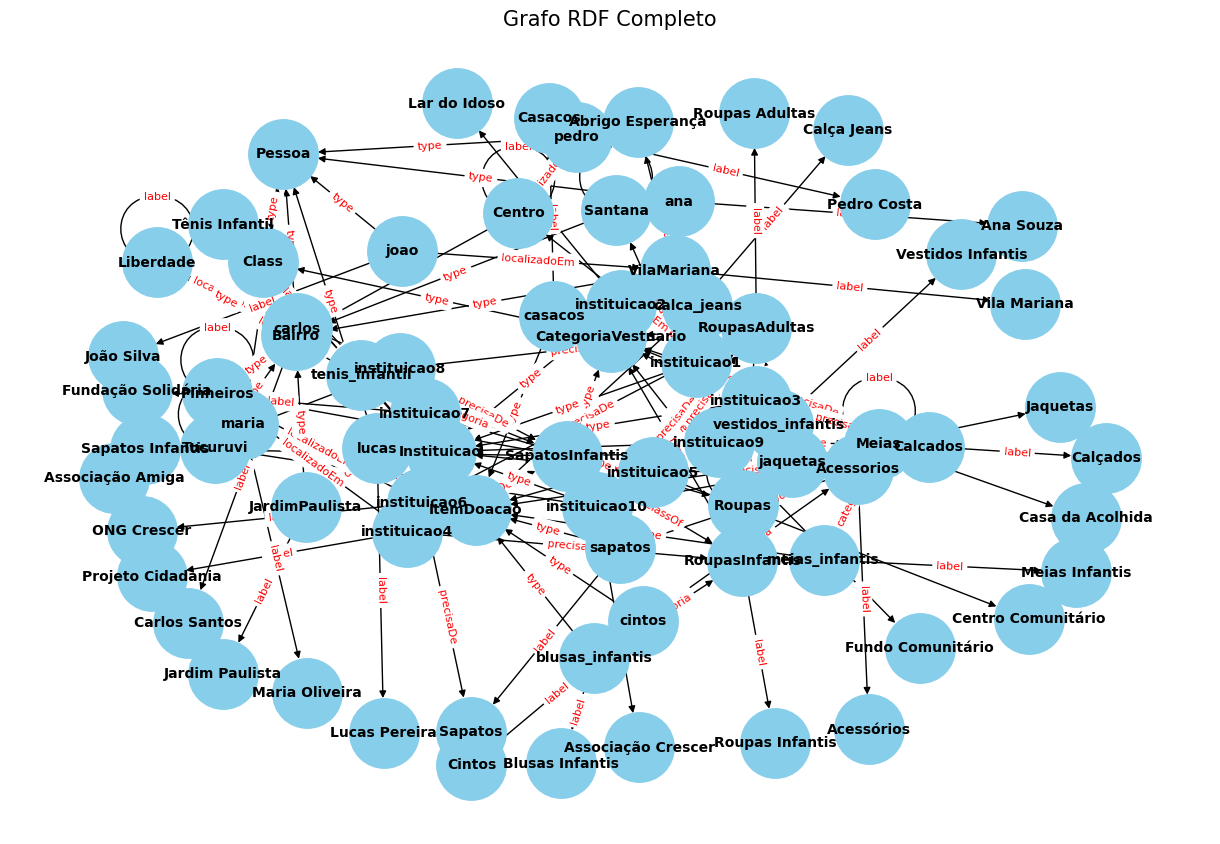

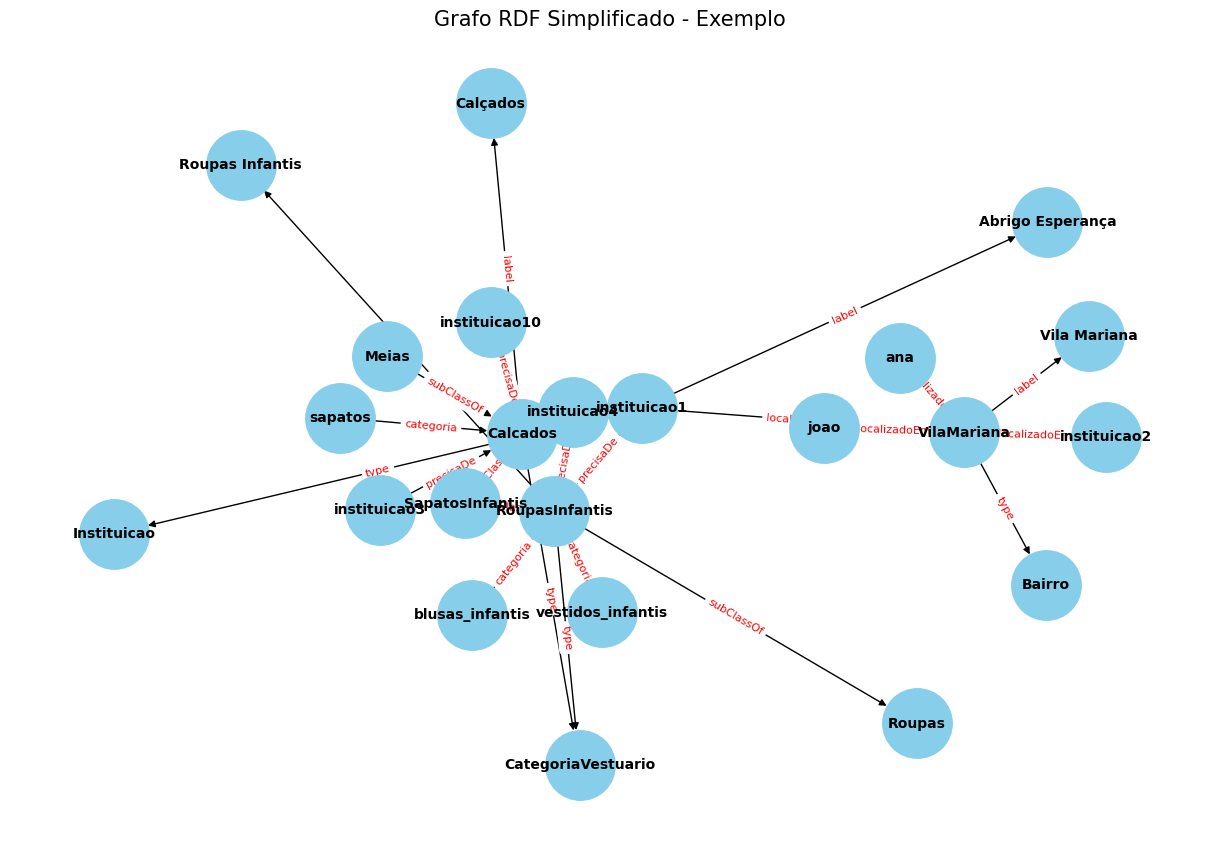

In [ ]:
# ======================================================
# Visualização de Grafos RDF com NetworkX e Matplotlib
# ======================================================
# Esta célula realiza o seguinte:
# 1. Importa bibliotecas necessárias: rdflib para RDF, networkx para grafos, matplotlib para visualização.
# 2. Carrega os dados RDF no grafo `g`.
# 3. Define a função `build_graph` para criar um grafo NetworkX a partir de um grafo RDF:
#    - Converte URIs em strings legíveis.
#    - Adiciona nós e arestas com labels.
#    - Permite filtrar sujeitos específicos para um grafo simplificado.
# 4. Define a função `draw_graph` para desenhar o grafo usando Matplotlib:
#    - Posiciona nós com `spring_layout`.
#    - Exibe nós, arestas e labels das arestas.
# 5. Gera e exibe:
#    - Grafo completo.
#    - Grafo simplificado (exemplo) filtrando apenas alguns sujeitos/entidades.

import rdflib
import networkx as nx
import matplotlib.pyplot as plt

g = rdflib.Graph()
g.parse(data=RDF_DATA, format="turtle")

def build_graph(rdf_graph, filter_subjects=None):
    """
    Constrói um grafo NetworkX a partir de um grafo RDF.
    filter_subjects: lista de sujeitos para filtrar (opcional, para grafo simplificado)
    """
    G = nx.DiGraph()
    for s, p, o in rdf_graph:
        s_str = s.split("#")[-1] if "#" in str(s) else str(s)
        p_str = p.split("#")[-1] if "#" in str(p) else str(p)
        o_str = o.split("#")[-1] if "#" in str(o) else str(o)

        # Filtra se desejar somente alguns sujeitos
        if filter_subjects and s_str not in filter_subjects and o_str not in filter_subjects:
            continue

        G.add_node(s_str)
        G.add_node(o_str)
        G.add_edge(s_str, o_str, label=p_str)
    return G

def draw_graph(G, title="Grafo RDF"):
    """
    Desenha o grafo usando Matplotlib
    """
    pos = nx.spring_layout(G, k=0.5, seed=42)
    plt.figure(figsize=(12,8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500, font_size=10, font_weight='bold', arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)
    plt.title(title, fontsize=15)
    plt.show()

# ---------------------------
# 1. Grafo completo
# ---------------------------
G_full = build_graph(g)
draw_graph(G_full, "Grafo RDF Completo")

# ---------------------------
# 2. Grafo simplificado (exemplo)
# ---------------------------
# Filtra apenas uma instituição, bairro e itens
example_subjects = ["instituicao1", "VilaMariana", "RoupasInfantis", "Calcados"]
G_simple = build_graph(g, filter_subjects=example_subjects)
draw_graph(G_simple, "Grafo RDF Simplificado - Exemplo")
